In [1]:
%matplotlib inline
import keras
import keras.backend     as K
import matplotlib.pyplot as plt
import numpy             as np

from keras.models         import Sequential
from keras.layers         import Convolution2D
from keras.layers         import AveragePooling2D
from keras.layers         import Activation
from keras.layers         import Dense
from keras.layers         import Flatten
from keras.layers         import Reshape
from keras.layers         import UpSampling2D
from keras.optimizers     import Adam
from keras.utils.np_utils import to_categorical
from keras.datasets       import mnist

path_to_fashion_mnist = '../../datasets/fashion-mnist/'

import sys
sys.path.insert(0, path_to_fashion_mnist)
from utils import mnist_reader

Using TensorFlow backend.


In [2]:
anomalies_number = 400
encoding_size    = 100
batch_size       = 64

# Dataset creation

## Dataset loading

First, we load the fashion MNIST dataset.

In [3]:
X_train_fashion, _ = mnist_reader.load_mnist(path_to_fashion_mnist + 'data/fashion', kind = 'train')
X_test_fashion, _  = mnist_reader.load_mnist(path_to_fashion_mnist + 'data/fashion', kind = 't10k')
X_fashion          = np.concatenate((X_train_fashion, X_test_fashion)).reshape(-1, 28, 28, 1)

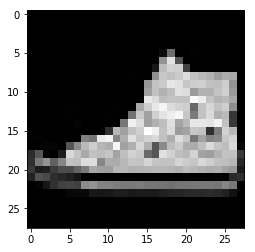

In [4]:
plt.imshow(X_fashion[35].squeeze(), cmap = 'gray')

Then we load the digit MNIST dataset.

In [5]:
(X_train_digits, _), (X_test_digits, _) = mnist.load_data()
X_digits                                = np.concatenate((X_train_digits, X_test_digits)).reshape(-1, 28, 28, 1)

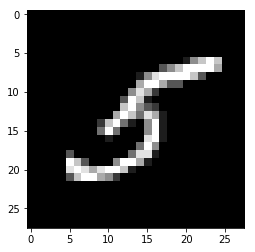

In [6]:
plt.imshow(X_digits[35].squeeze(), cmap = 'gray')

## Anomaly dataset creation creation

Now, we extract `anomaly_number` images from the fashion MNIST dataset. Then, we create a big dataset with all the MNIST digits and these `anomaly number` images.

In [7]:
anomalies = np.random.permutation(X_fashion)[:400]

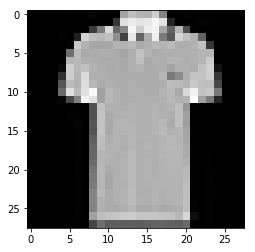

In [8]:
plt.imshow(anomalies[39].squeeze(), cmap = 'gray')

In [9]:
X = np.concatenate((X_digits, anomalies))
X = np.random.permutation(X)
X = (X - X.mean()) / X.std()

# Replicator network

The intuition that I have on replicator network is that they are autoencoders (a highly specialized compressor and decompressor) trained on the whole dataset. The idea is that the "usual" will be handled quite well by our autoencoder in the sense that the structure of the data will be well understood, i.e. the image produced by encoding and then decoding will be very close to the original one. To discover anomalies in our dataset, we will try to look for images that differ a lot from their compressed and decompressed counterparts.

Let's first build and train this autoencoder.

In [10]:
encoder = Sequential([
    Convolution2D(64, (3, 3), padding = 'same', input_shape = (28, 28, 1), activation = 'relu'),
    Convolution2D(64, (3, 3), padding = 'same', activation = 'relu'),
    AveragePooling2D(),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(encoding_size),
])

In [11]:
decoder = Sequential([
    Dense(49, input_shape = (encoding_size,), activation = 'relu'),
    Reshape((7, 7, 1)),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    Convolution2D(128, (3, 3), padding = 'same', activation = 'relu'),
    UpSampling2D(),
    Convolution2D(64, (3, 3), padding = 'same', activation = 'relu'),
    Convolution2D(64, (3, 3), padding = 'same', activation = 'relu'),
    UpSampling2D(),
    Convolution2D(1, (3, 3), padding = 'same', activation = 'tanh')
])

In [12]:
autoencoder = Sequential([
    encoder,
    decoder
])
autoencoder.compile(optimizer = Adam(1e-4), loss = 'mse')

In [13]:
fit_params = {
    'x'               : X,
    'y'               : X,
    'batch_size'      : batch_size,
    'epochs'          : 50,
    'validation_split': 0.15
}

In [14]:
autoencoder.fit(**fit_params)

Train on 59840 samples, validate on 10560 samples
Epoch 1/50
59840/59840 [==============================] - 132s - loss: 0.4898 - val_loss: 0.4071
Epoch 2/50
59840/59840 [==============================] - 133s - loss: 0.3939 - val_loss: 0.3826
Epoch 3/50
59840/59840 [==============================] - 138s - loss: 0.3772 - val_loss: 0.3707
Epoch 4/50
59840/59840 [==============================] - 132s - loss: 0.3682 - val_loss: 0.3641
Epoch 5/50
59840/59840 [==============================] - 129s - loss: 0.3626 - val_loss: 0.3640
Epoch 6/50
59840/59840 [==============================] - 129s - loss: 0.3584 - val_loss: 0.3576
Epoch 7/50
59840/59840 [==============================] - 129s - loss: 0.3553 - val_loss: 0.3538
Epoch 8/50
59840/59840 [==============================] - 129s - loss: 0.3530 - val_loss: 0.3530
Epoch 9/50
59840/59840 [==============================] - 129s - loss: 0.3508 - val_loss: 0.3492
Epoch 10/50
59840/59840 [==============================] - 129s - loss: 0.349

Now that the network is trained, we want to get an idea of the quality of compression on "normal" data and on "anomalies".

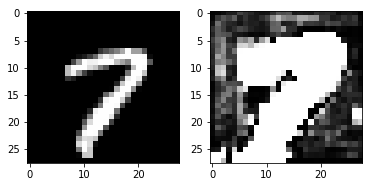

In [15]:
digit_img = np.expand_dims(X_digits[2929], 0)
digit_img_ = autoencoder.predict(digit_img)
plt.subplot(1, 2, 1)
plt.imshow(digit_img[0].squeeze(), cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(digit_img_[0].squeeze(), cmap = 'gray')

We can see that the digit images are recovered pretty well, that is a good first step for what we are trying to implement.

Now let's do the same thing with images from the fashion dataset.

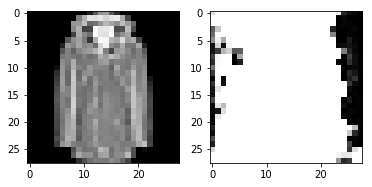

In [16]:
fashion_img = np.expand_dims(X_fashion[22], 0)
fashion_img_ = autoencoder.predict(fashion_img)
plt.subplot(1, 2, 1)
plt.imshow(fashion_img[0].squeeze(), cmap = 'gray')
plt.subplot(1, 2, 2)
plt.imshow(fashion_img_[0].squeeze(), cmap = 'gray')

The quality of the recovered image is terrible, which is really good for our usecase. Since these images are very different from the "normal" ones, the autoencoder haven't manage to capture their structures. We can hope that anomalous images will have a reconstruction loss much higher than normal ones.

In [17]:
autoencoder.save_weights('../models/autoencoder_%dD.h5')

In [18]:
autoencoder.load_weights('../models/autoencoder_%dD.h5')

In [19]:
X_ = autoencoder.predict(X, batch_size = 128)

In [20]:
pixel_mse = ((X - X_) ** 2).squeeze()
image_mse = pixel_mse.reshape(pixel_mse.shape[0], -1).mean(axis = 1)

(array([  2.43000000e+02,   1.93400000e+03,   4.86900000e+03,
          7.79400000e+03,   9.72900000e+03,   1.02240000e+04,
          9.57200000e+03,   7.92300000e+03,   5.99800000e+03,
          4.45200000e+03,   2.96600000e+03,   1.89300000e+03,
          1.17300000e+03,   6.73000000e+02,   3.93000000e+02,
          2.39000000e+02,   1.30000000e+02,   6.40000000e+01,
          4.10000000e+01,   1.90000000e+01,   1.40000000e+01,
          1.40000000e+01,   1.00000000e+01,   6.00000000e+00,
          1.00000000e+01,   4.00000000e+00,   4.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   5.00000000e+00]),
 array([ 0.0393955 ,  0.08535219,  0.13130888,  0.17726557,  0.22322226,
         0.26917895,  0.31513564,  0.36109233,  0.40704902,  0.45300571,
         0.4989624 ,  0.54491909,  0.59087578,  0.63683247,  0.68278916,
         0.72874585,  0.77470254,  0.82065923,  0.86661592,  0.91257261,
         0.9585293 ,  1.00448599,  1.05044268,  1.09639937,  1.14235606,
         1.18

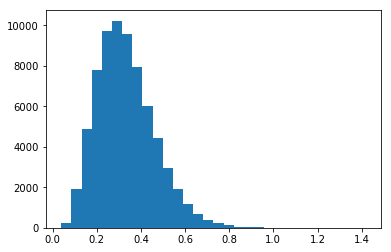

In [21]:
plt.hist(image_mse, bins = 30)

In [22]:
reconstruction_loss_sort_idx = image_mse.argsort()

In [23]:
def create_visualization(X, n, loss_idx):
    plt.figure(figsize = (15, 15))
    X_high_loss = X[loss_idx[-n**2:]]
    for i in range(n):
        for j in range(n):
            idx = i * n + j
            plt.subplot(n, n, idx + 1)
            img = X_high_loss[idx].squeeze()
            plt.imshow(img, cmap = 'gray')
            plt.axis('off')

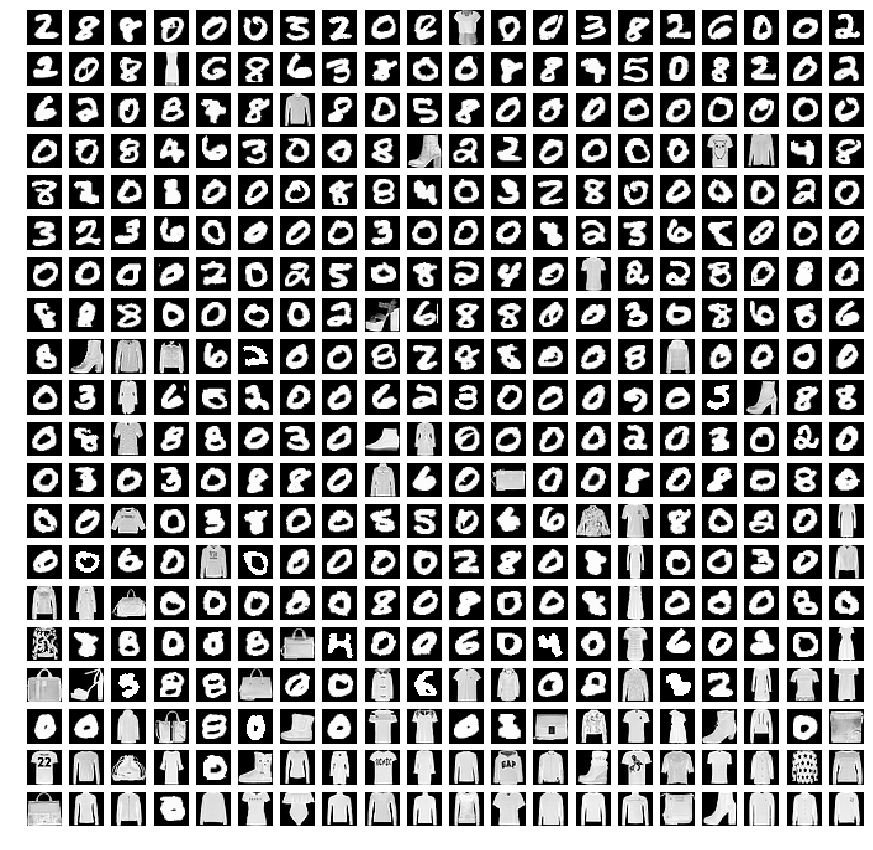

In [24]:
create_visualization(X, 20, reconstruction_loss_sort_idx)